## 2 모델 적용 


### 2.3 KcBert


&nbsp;&nbsp;  ■ 참고 사이트 : 1)[KcBERT](https://github.com/Beomi/KcBERT) 홈페이지
2) [Hugging Face 공유 모델 Model : beomi/kcbert-base](https://huggingface.co/beomi/kcbert-base)
> **KcBERT 에 대한 간단한 소개** \
SKT의 KoBERT에 이어 네이버 댓글 데이터, 신조어 등을 반영한 데이터로 바닥부터 학습한 KcBERT 가 공개 되었습니다. \
공개된 한국어 BERT는 대부분 한국어 위키, 뉴스 기사, 책 등 잘 정제된 데이터(문어체)를 기반으로 한 반면, 실제 포털 댓글 등에서 나타나는 구어체 특징, 신조어, 오탈자 등을 반영한 모델은 없었습니다. \
KcBERT는 이러한 측면을 개선하기 위해서 <code>네이버 댓글과 대댓글(구어체)</code>을 수집하여 토크나이저와 모델을 처음부터 학습한 모델입니다. \
그동안 오픈 소스로 공개된 한글 버트들은 real-world와의 차이 때문에 실제 적용해 보면 제 성능이 나오지 않는 경우가 많은데, \
이렇게 real-world 데이터를 반영하여 만들어진 모델은 실제 적용 측면과 성능 면에서 긍정적일 것으로 보입니다. \
학습셋 : 2019.01.01 ~ 2020.06.15 사이에 작성된 댓글 많은 뉴스 기사들의 댓글과 대댓글을 모두 수집한 데이터 (12.5GB, 8.9천만개 문장) \
사전(Vocabulary) 크기 : 30000 

■ 학습 방법 :
* Hugging Face 공유 모델 다운로드 방식으로 학습 : .from_pretrained("beomi/kcbert-base") \
 (KcBERT 저자(Beomi님)가 직접 올린 모델로 신뢰 가능)
* ignite 등 보일러플레이트를 활용하여 기능별로 학습을 진행 - 김기현 강의 내용 중 추천 방식 ([Ignite pytorch 사이트](https://github.com/pytorch/ignite))
* 토크나이저 : 메캅 + BPE 를 사용하여 학습 or BPE 로만 학습 후 비교 - 김기현 강의 내용 중 추천 방식

<br><br>
#### (1) 환경 설치 및 라이브러리 임포트 
- [파이토치 설치 (설치환경별 코드 상이)](https://pytorch.org/)


In [58]:
import pandas as pd
import numpy as np
import torch
import transformers
import matplotlib.pyplot as plt

In [59]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0"

# GPU 사용 지정
if torch.cuda.is_available():     
    device = torch.device('cuda')

# If not... CPU 사용 지정
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

<br><br>
#### (2) 데이터 로딩 
- 데이터 탐색 및 전처리 시 저장한 <code>train_data.tsv</code>, <code>test_data.tsv</code> 불러옵니다.
- 각 데이터는 label(예측해야할 값)과 text(예측에 사용될 값)로 이루어져 있습니다.
- 2.1 구글버트에서 로딩했던 방법과 동일합니다.

In [60]:
# Load the dataset 
train = pd.read_csv("data/train_data.tsv", sep ='\t', header=0, encoding='utf-8', names=['label','text'])
test = pd.read_csv("data/test_data.tsv", sep ='\t', header=0, encoding='utf-8', names=['label','text'])

# sentences 개수
print('Training sentences 개수: {:,}'.format(train.shape[0]))
print('Test sentences 개수: {:,}\n'.format(test.shape[0]))

# train/test 각각의 text 와 label을 리스트로 가져옵니다.
train_texts = train.text.values.tolist()
train_labels = train.label.values.tolist()
test_texts = test.text.values.tolist()
test_labels = test.label.values.tolist()

# 데이터 모양 출력
train_texts[:2] , train_labels[:2]

Training sentences 개수: 34,396
Test sentences 개수: 8,327



(['고객님 정보 확인 불가 문의 안녕하세요 당일 고객님 분실정지 진행하려고 하는데 인입시 고객정보가 조회되지 않습니다 처리결과 값이 올바르지 않습니다 라고 나오면 정보조회의 기본정보 성명 생년월일등 가 확인되지 않습니다 해당 내용 확인 부탁 드립니다 감사합니다',
  '긴급 tv m oss 결과보고시 기존바코드 확인안되어hds연동할수 없음 업무경로 데이터 국사 원주 회선번호 수리접수번호 상품정보 서비스계약번호 연락처 이윤범 현장 확인사항 수리오더로 결과보고시 연동시 기존바코드가 올라오지않아 교체업무 진행을 할 수 가 없습니다 완료보고 확인시 기존바코드에 빌트인 로 확인되며 단말원부확인시 댁내설치된기존바코드 확인시 사용 사용으로 되어 있습니다 긴급건으로 확인 및 조치 부탁 드립니다'],
 ['ASM34824', 'ASM31688'])

<br><br>
#### (3) 데이터 포맷 변경 
1. label(Output : y) 정수화 - label 포맷을 str 문자에서 int 정수로 매핑 
2. text(Input : x) 토큰화 - 데이터를 BERT를 학습 할 수 있는 형식으로 변환합니다. \
  . 문장별 토큰화 \
  . vocab 기반 정수 인덱스 매핑 & padding \
  . input text mask 적용 \
  (text 토큰화는 아래 3가지 적용방식에 따로 구현하였으니 참고바랍니다.)

In [61]:
# 1. label(Output : y) 정수 인코딩 
label_idx = {j:i for i,j in enumerate(sorted(set(test.label.values.tolist())))}  # dict{ 'ASM14261' : 0 , 'ASM14262' : 1 , ...} 
print('labels 개수 :',len(label_idx)) 
train_labels = [label_idx[i] for i in train.label.values.tolist()]
test_labels = [label_idx[i] for i in test.label.values.tolist()]
print('Train Data 개수 :',len(train_labels) , '\nTest Data 개수 :',len(test_labels))
print('\n▶ label 정수 인덱스화 예시 :' , test.label.values.tolist()[:3], '->', test_labels[:3] )

labels 개수 : 183
Train Data 개수 : 34396 
Test Data 개수 : 8327

▶ label 정수 인덱스화 예시 : ['ASM14326', 'ASM30034', 'ASM30014'] -> [6, 65, 58]


<br><br>
#### (4) 모델 학습

* Hugging Face 공유 모델 다운로드 방식으로 학습 : .from_pretrained("beomi/kcbert-base") \
 (KcBERT 저자(Beomi님)가 직접 올린 모델로 신뢰 가능)
* Ignite 등 보일러플레이트를 활용하여 기능별로 학습을 진행 - 김기현 강의 내용 중 추천 방식 ([Ignite pytorch 사이트](https://github.com/pytorch/ignite))
* !python train.py 파이썬 스크립트를 활용한 학습 시행
* 한글형태소분석 적용 여부 비교 : Mecab  - 김기현 강의 내용 중 추천 방식

<br><br>
#### ■ Hugging Face 공유 모델 적용 (.from_pretrained)
- Unknown 없이 대부분 토큰화가 잘 적용된 것을 확인 할 수 있습니다.

In [62]:
from transformers import BertTokenizer, AutoTokenizer, BertForSequenceClassification, BertModel

# Load the BERT tokenizer in Hugging Face share models version.
tokenizer = AutoTokenizer.from_pretrained("beomi/kcbert-base")
model = BertForSequenceClassification.from_pretrained(
        "beomi/kcbert-base",
        num_labels=len(label_idx)
    )

Some weights of the model checkpoint at beomi/kcbert-base were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initiali

In [63]:
# 2. text(Input : x) 토큰화
# 예시) 원본 text를 출력 
print('train data 원본 문장: ', train_texts[0])

# 예시) 문장을 토큰화 적용 
print('\n토큰화 적용: ', tokenizer.tokenize(train_texts[0]))

# 예시) 문장의 토큰을 token ids(정수)로 매핑한 결과 출력
print('\nToken ids 적용: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(train_texts[0])))

train data 원본 문장:  고객님 정보 확인 불가 문의 안녕하세요 당일 고객님 분실정지 진행하려고 하는데 인입시 고객정보가 조회되지 않습니다 처리결과 값이 올바르지 않습니다 라고 나오면 정보조회의 기본정보 성명 생년월일등 가 확인되지 않습니다 해당 내용 확인 부탁 드립니다 감사합니다

토큰화 적용:  ['고객', '##님', '정보', '확인', '불가', '문의', '안녕', '##하세요', '당일', '고객', '##님', '분', '##실', '##정지', '진행', '##하려고', '하는데', '인', '##입', '##시', '고객', '##정보', '##가', '조회', '##되지', '않습니다', '처리', '##결과', '값', '##이', '올바', '##르지', '않습니다', '라고', '나오면', '정보', '##조', '##회의', '기본', '##정보', '성', '##명', '생', '##년', '##월', '##일', '##등', '가', '확인', '##되지', '않습니다', '해당', '내용', '확인', '부탁', '드립니다', '감사합니다']

Token ids 적용:  [14877, 4275, 9868, 9342, 13724, 22748, 19017, 8482, 27316, 14877, 4275, 1614, 4353, 19798, 10308, 9292, 8498, 2454, 4307, 4039, 14877, 11176, 4009, 19903, 9441, 11851, 9810, 11596, 210, 4017, 22173, 14996, 11851, 9056, 10046, 9868, 4194, 16287, 8932, 11176, 1856, 4268, 1821, 4482, 4333, 4046, 4086, 197, 9342, 9441, 11851, 11174, 9132, 9342, 9562, 23295, 10483]


<br><br>
#### ■ Ignite 보일러플레이트를 활용한 학습 프로세스 구축
> **보일러 플레이트(boilerplate)란,** 최소한의 변경으로 여러곳에서 재사용되며, 반복적으로 비슷한 형태를 띄는 코드를 말합니다. \
> 학습을 수행 할 때, 모델과 dataset만 바꿔서 재사용 가능한 코드가 있으면 반복적인 실험을 수행할 때 편리할 것 입니다. \
> 이러한 아이디어 기반의 템플릿(Template)이 Ignite 와 같은 보일러플레이트 입니다. 

> **보일러 플레이트를 사용해야 하는 이유** \
==> **Jupyter Notebook vs. Python script** \
• Jupyter Notebook은 실습 위주의 환경에 적합 \
• 대량의 실험(e.g. hyper-parameter 튜닝)에 적합하지 않음 \
• 복잡한 프로그램 개발에 적합하지 않음 \
• 실무에서는 Linux Console 위주로 진행됨 \
• Python script 파일 실행 시, argument parsing을 통해 hyper-parameter 입력

* [보일러 플레이트에 대한 이해를 돕는 블로그](https://research.sualab.com/development/2020/06/18/pytorch-boilerplate.html)
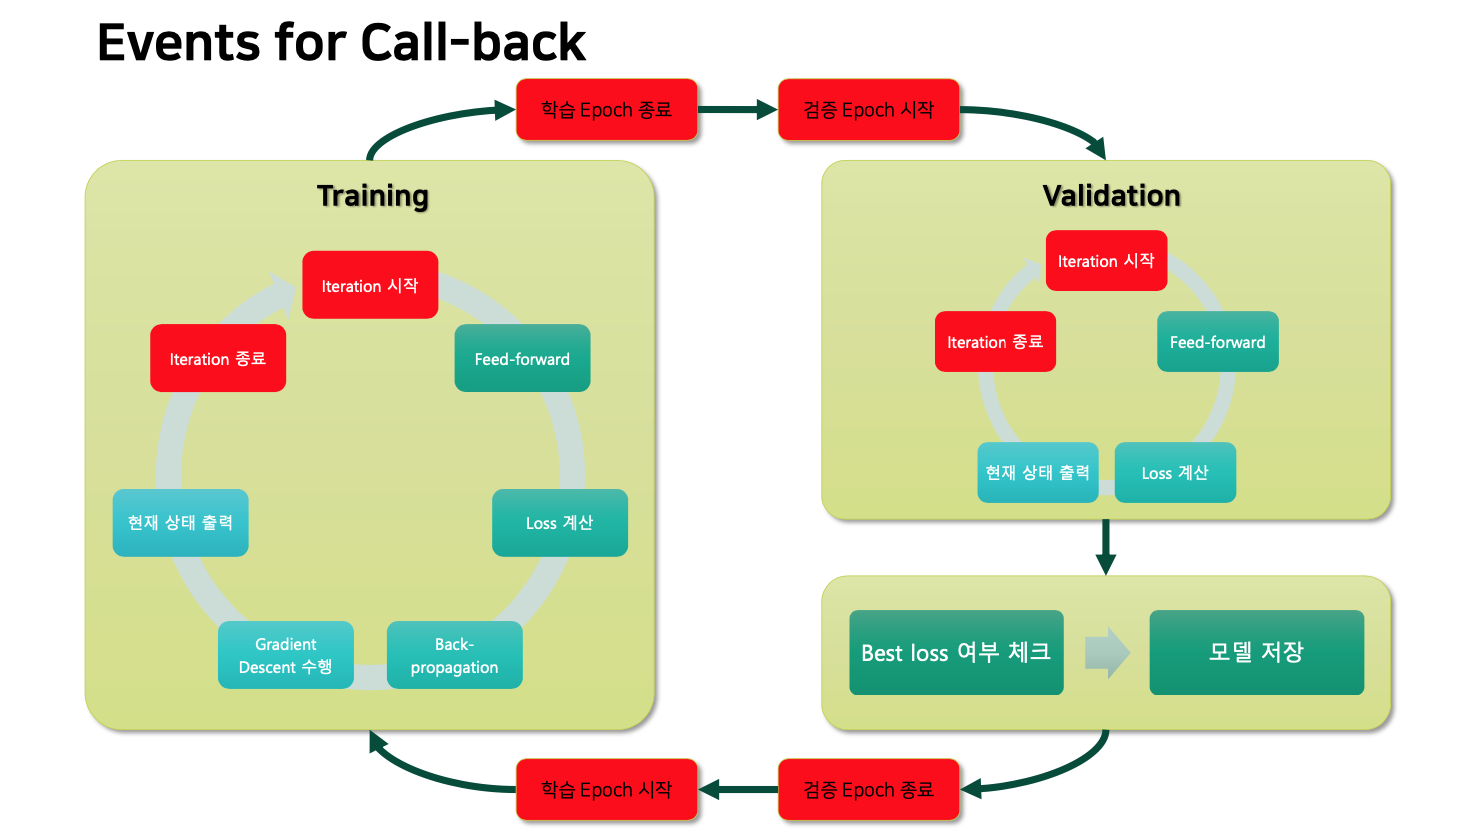

<br><br>
**아래부터는 ignite 코드에 대한 기능 구현 설명이며, 이후 Python script(.py)로 각각의 기능을 분할 저장할 것이고, import로 불러내어 학습을 진행할 예정입니다.**

[필요 모듈 예시] \
• model.py: Architecture가 정의된 클래스 \
• trainer.py: Model을 학습하기 위한 코드 \
• dataloader.py: 데이터를 불러와 전처리를 수행하고, 신경망에 넣기 좋은 형태로 변환 \
• train.py: 사용자로부터 hyper-param을 받아, Model과 Trainer, Loader를 선언하고 학습  \
• predict.py: 사용자로부터 Model과 input을 받아, 추론을 수행
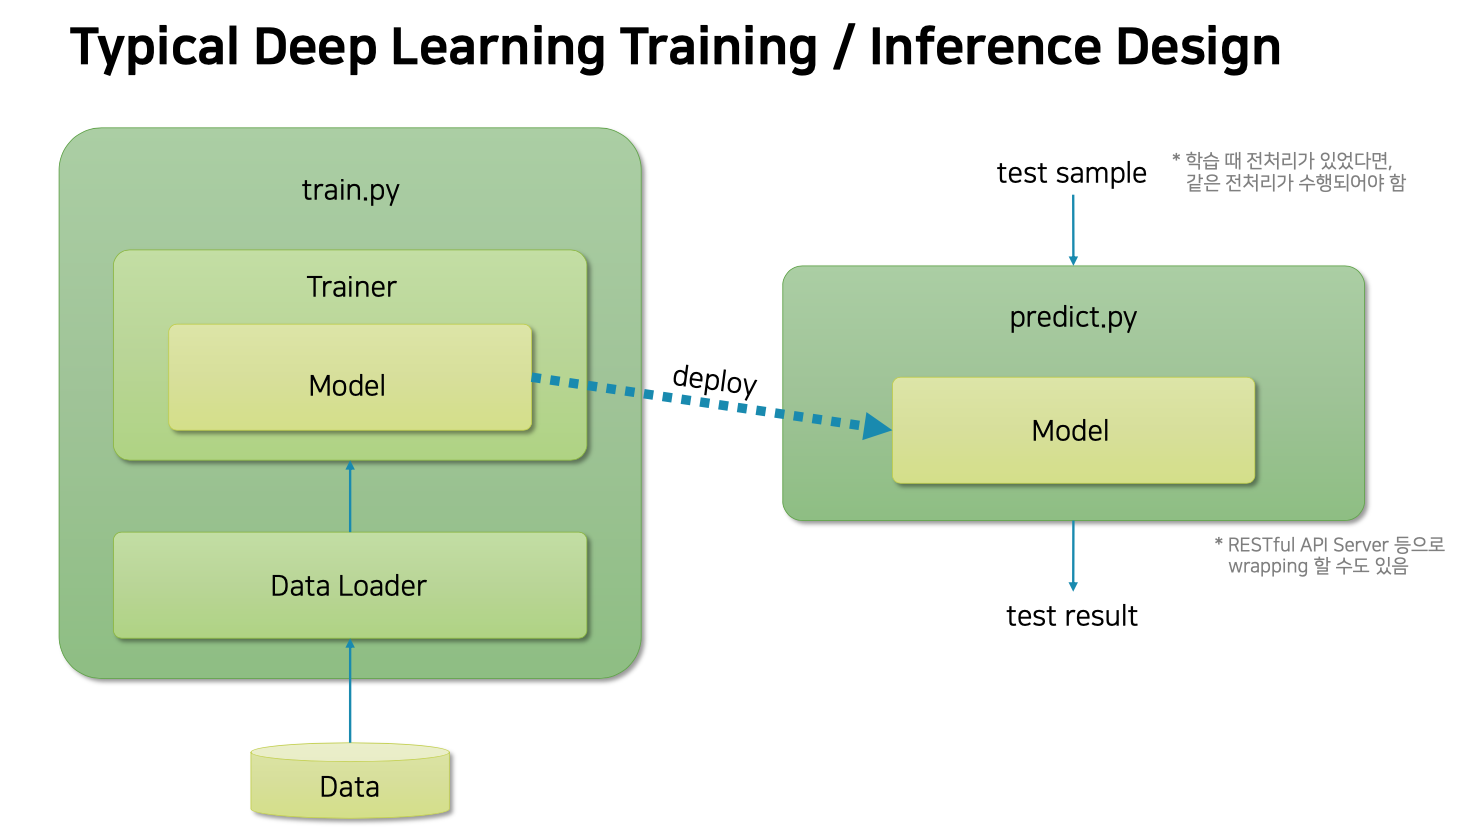

1) model.py: Architecture가 정의된 클래스
* 아래와 같이 custom 형태의 모델 아키텍쳐가 들어갑니다.
* 이번 학습에서는 허깅페이스에서 모델 아키텍쳐(BertForSequenceClassification)를 다운로드하기 때문에 따로 model.py가 필요하지 않습니다.

In [64]:
# model.py 예시 
class BertClassifier(nn.Module):
    def __init__(self, bert: BertModel, num_labels):
        super(BertClassifier, self).__init__()
        hidden_size = 768
        self.bert = bert
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(hidden_size, num_labels)
        nn.init.normal_(self.classifier.weight,std=0.02)
        
    def forward(self, sent_id, mask):#pass the inputs to the model  
        outputs = self.bert(sent_id, mask)
        pooled_output = outputs[1]
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)   
        
        return logits

2) dataloader.py: 데이터를 불러와 전처리를 수행하고, 신경망에 넣기 좋은 형태로 변환
- texts를 버트에서 필요한 인풋 양식인 input_ids, attention_mask 를 구성해줍니다.

In [65]:
# dataloader.py
import torch
from torch.utils.data import Dataset
from torchtext import data

class TokenizerWrapper():
    # 클래스 정의 할 때 tokenizer, max_length 를 받음
    def __init__(self, tokenizer, max_length):
        self.tokenizer = tokenizer
        self.max_length = max_length
    # collate 함수를 이용해 배치 단위로 필요한 input 데이터양식으로 구성 (input_ids, attention_mask 등 )
    def collate(self, samples):
        texts = [s['text'] for s in samples]
        labels = [s['label'] for s in samples]
        encoding = self.tokenizer(
            texts,
            padding=True,
            truncation=True,
            return_tensors="pt",
            max_length=self.max_length
        )
        return {
            'text': texts,
            'input_ids': encoding['input_ids'],
            'attention_mask': encoding['attention_mask'],
            'labels': torch.tensor(labels, dtype=torch.long),
        }

class BertDataset(Dataset):
    # 클래스 정의 할 때 texts, labels 리스트를 받음 
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels
    # texts 길이
    def __len__(self):
        return len(self.texts)
    # 특정 인덱스 데이터에 대한 dict 처리
    def __getitem__(self, item):
        text = str(self.texts[item])
        label = self.labels[item]
        return {
            'text': text,
            'label': label,
        }

3) trainer.py: Model을 학습하기 위한 코드 

- 이 파트는 딥러닝 학습에서 동일하게 사용되는 train 과 validate 기능이 구현되어 있습니다.
- 대부분의 보일러 플레이터가 이것을 자동화 해주고 있기 때문에 편리하게 사용가능합니다.
- [Ignite 설치 방법](https://github.com/pytorch/ignite)

> ignite 전체 컨셉은 event가 끝났을 때 무엇을 실행할지 지시하는 방식으로 이뤄집니다. \
예) Events.EPOCH_COMPLETED 

> 크게 2개의 클래스로 이루어집니다. 
> 1. EngineForBert - 학습에 필요한 도구를 정리해 둔 클래스 def train, def validate, def attach(통계출력용) 
> 2. BertTrainer - 도구를 사용하여 일련의 학습 과정을 지시 (예) engine.add_event_handler()

In [66]:
# ignite 설치 
# !pip install pytorch-ignite

In [67]:
# trainer.py
import torch
import torch.nn.utils as torch_utils
from copy import deepcopy
import numpy as np

from ignite.engine import Engine
from ignite.engine import Events
from ignite.metrics import Accuracy, Loss, RunningAverage
from ignite.contrib.handlers.tqdm_logger import ProgressBar
from ignite.engine import Events

from kcbert.utils import get_grad_norm, get_parameter_norm 

VERBOSE_SILENT = 0
VERBOSE_EPOCH_WISE = 1
VERBOSE_BATCH_WISE = 2

from kcbert.trainer_base import Trainer, MyEngine

from transformers import AutoTokenizer
from transformers import BertForSequenceClassification


class EngineForBert(MyEngine):
    def __init__(self, func, model, crit, optimizer, scheduler, config): 
        super().__init__(func, model, crit, optimizer, config) 
        
        self.scheduler = scheduler
        self.best_loss = np.inf
        self.best_model_loss = None
        self.best_acc = 0
        self.best_model_acc = None        
        
    @staticmethod
    def train(engine, mini_batch):
        # 학습모드
        # 모든 모델 파라미터의 gradients(기울기)를 재설정  .zero_grad()
        engine.model.train() 
        engine.optimizer.zero_grad()

        x, y = mini_batch['input_ids'], mini_batch['labels']
        x, y = x.to(engine.device), y.to(engine.device)
        mask = mini_batch['attention_mask']
        mask = mask.to(engine.device)

        x = x[:, :engine.config.max_length]

        # feed-forward
        y_hat = engine.model(x, attention_mask=mask)[0]
        
        # loss 계산 및 backward
        loss = engine.crit(y_hat, y)
        loss.backward()

        # 'y'가  one-hot 인코딩 이므로  LongTensor 형태로 변환해야 accuracy 산정 가능
        if isinstance(y, torch.LongTensor) or isinstance(y, torch.cuda.LongTensor):
            accuracy = (torch.argmax(y_hat, dim=-1) == y).sum() / float(y.size(0))
        else:
            accuracy = 0

        # 학습시 파라미터 발산여부를 확인 가능 (값이 일정한지 체크)
        p_norm = float(get_parameter_norm(engine.model.parameters()))
        g_norm = float(get_grad_norm(engine.model.parameters()))

        # gradient descent 한 스텝 이동
        engine.optimizer.step()
        engine.scheduler.step()

        return {
            'loss': float(loss),
            'accuracy': float(accuracy),
            '|param|': p_norm,
            '|g_param|': g_norm,
        }

    @staticmethod
    def validate(engine, mini_batch):
        # valid 모드
        engine.model.eval()

        with torch.no_grad():
            x, y = mini_batch['input_ids'], mini_batch['labels']
            x, y = x.to(engine.device), y.to(engine.device)
            mask = mini_batch['attention_mask']
            mask = mask.to(engine.device)

            x = x[:, :engine.config.max_length]

            # feed-forward
            y_hat = engine.model(x, attention_mask=mask)[0] # 참고 : logits = outputs[0] in BertForSequenceClassification

            loss = engine.crit(y_hat, y)

            if isinstance(y, torch.LongTensor) or isinstance(y, torch.cuda.LongTensor):
                accuracy = (torch.argmax(y_hat, dim=-1) == y).sum() / float(y.size(0))
            else:
                accuracy = 0

        return {
            'loss': float(loss),
            'accuracy': float(accuracy),
        }
    
    @staticmethod
    def attach(train_engine, validation_engine, verbose=VERBOSE_BATCH_WISE):
        # ignite 내 attach 함수를 사용하여 반복되는 코드를 줄일 수 있습니다.
        def attach_running_average(engine, metric_name):
            RunningAverage(output_transform=lambda x: x[metric_name]).attach(
                engine,
                metric_name,
            ) 

        training_metric_names = ['loss', 'accuracy', '|param|', '|g_param|']

        for metric_name in training_metric_names:
            attach_running_average(train_engine, metric_name)
            
        # ignite 프로그래스 바를 통해 학습여부 체크 가능 
        if verbose >= VERBOSE_BATCH_WISE:
            pbar = ProgressBar(bar_format=None, ncols=120)
            pbar.attach(train_engine, training_metric_names)

        # 각 epoch 후에 통계가 표시
        if verbose >= VERBOSE_EPOCH_WISE:
            # train_engine 이 수행되고 있고(on), EPOCH_COMPLETED 이벤트가 발생 했을 때 수행됨
            @train_engine.on(Events.EPOCH_COMPLETED)
            def print_train_logs(engine):
                # 출력
                print('Epoch {} - |param|={:.2e} |g_param|={:.2e} loss={:.4e} accuracy={:.4f}'.format(
                    engine.state.epoch,
                    engine.state.metrics['|param|'],
                    engine.state.metrics['|g_param|'],
                    engine.state.metrics['loss'],
                    engine.state.metrics['accuracy'],
                ))
                # 파일로 저장
                with open(engine.config.txt_fn, "a") as f:
                    f.write('Epoch {} - |param|={:.2e} |g_param|={:.2e} loss={:.4e} accuracy={:.4f}\n'.format(
                    engine.state.epoch,
                    engine.state.metrics['|param|'],
                    engine.state.metrics['|g_param|'],
                    engine.state.metrics['loss'],
                    engine.state.metrics['accuracy'],
                ))
                    
        validation_metric_names = ['loss', 'accuracy']
        
        for metric_name in validation_metric_names:
            attach_running_average(validation_engine, metric_name)

        # Do same things for validation engine.
        if verbose >= VERBOSE_BATCH_WISE:
            pbar = ProgressBar(bar_format=None, ncols=120)
            pbar.attach(validation_engine, validation_metric_names)

        if verbose >= VERBOSE_EPOCH_WISE:
            # validation_engine 이 수행되고 있고(on), EPOCH_COMPLETED 이벤트가 발생 했을 때 수행됨
            @validation_engine.on(Events.EPOCH_COMPLETED)
            def print_valid_logs(engine):
                print('Valid - loss={:.4e} accuracy={:.4f} best_loss={:.4e} best_acc={:.4f}'.format(
                    engine.state.metrics['loss'],
                    engine.state.metrics['accuracy'],
                    engine.best_loss,
                    engine.best_acc,
                ))
                with open(engine.config.txt_fn, "a") as f:
                    f.write('Valid - loss={:.4e} accuracy={:.4f} best_loss={:.4e} best_acc={:.4f}\n'.format(
                    engine.state.metrics['loss'],
                    engine.state.metrics['accuracy'],
                    engine.best_loss,
                    engine.best_acc,
                ))                
                
    @staticmethod
    def check_best(engine):
        loss = float(engine.state.metrics['loss'])
        if loss <= engine.best_loss: # If current epoch returns lower validation loss,
            engine.best_loss = loss  # Update lowest validation loss.
            engine.best_model = deepcopy(engine.model.state_dict()) # Update best model weights.

    @staticmethod
    def check_best_acc(engine):
        acc = float(engine.state.metrics['accuracy'])
        if acc >= engine.best_acc: # If current epoch returns upper validation acc,
            engine.best_acc = acc  # Update lowest validation loss.
            engine.best_model2 = deepcopy(engine.model.state_dict()) # Update best model weights.
          
               
    @staticmethod
    def save_model(engine, train_engine, config, index_to_label, **kwargs):
        torch.save(
            {
                'bert_bm_loss': engine.best_model_loss,  
                'bert_bm_acc': engine.best_model_acc,
                'config': config,
                'classes': index_to_label,
                **kwargs
            }, config.model_fn
        ) 
    
class BertTrainer(Trainer):
    def __init__(self, config):
        self.config = config

    def train(
        self,
        model, crit, optimizer, scheduler,
        train_loader, valid_loader, index_to_label,
    ):
        train_engine = EngineForBert(
            EngineForBert.train, # function
            model, crit, optimizer, scheduler, self.config
        )
        validation_engine = EngineForBert( 
            EngineForBert.validate, # function
            model, crit, optimizer, scheduler, self.config
        )

        EngineForBert.attach(
            train_engine,
            validation_engine,
            verbose=self.config.verbose
        )

        def run_validation(engine, validation_engine, valid_loader):
            validation_engine.run(valid_loader, max_epochs=1)
                               
        train_engine.add_event_handler(
            Events.EPOCH_COMPLETED, # event
            run_validation, # function
            validation_engine, valid_loader, # arguments
        )
        
        validation_engine.add_event_handler(
            Events.EPOCH_COMPLETED, # event
            EngineForBert.check_best, # function
        )
        
        validation_engine.add_event_handler(
            Events.EPOCH_COMPLETED, # event
            EngineForBert.check_best_acc, # function
        )
        
        validation_engine.add_event_handler(
            Events.EPOCH_COMPLETED, # event
            EngineForBert.save_model, # function
            train_engine, self.config, index_to_label,  # arguments
        )
        
        train_engine.run(
            train_loader,
            max_epochs=self.config.n_epochs,
        )
#         model.load_state_dict(validation_engine.best_model) 
        return validation_engine.best_model_loss , validation_engine.best_model_acc

4) train.py: 사용자로부터 hyper-param을 받아, Model과 Trainer, Loader를 선언하고 학습
- main.py 에 해당하는 파일
- 전체 학습 프로세스를 지정

In [ ]:
# train.py
import argparse
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from transformers import AutoTokenizer
from transformers import BertForSequenceClassification
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

# python script 방식에서 hyper-parameters를 아래 argparse 패키지를 사용하여 받음.
def define_argparser():
    p = argparse.ArgumentParser()
    p.add_argument('--model_fn', default='kcbert_1.pth') # 저장할 모델 이름 ('sample.pth') 
    p.add_argument('--txt_fn', default='kcbert_1.txt') # 저장할 파일 이름 ('sample.txt') 
    p.add_argument('--train_fn', default='data/train_data.tsv') # train 대상 파일
    p.add_argument('--test_fn', default='data/test_data.tsv')  # test 대상 파일
    p.add_argument('--pretrained_model_name', type=str, default='beomi/kcbert-base') # bert 모델
    p.add_argument('--gpu_id', type=int, default=-1)
    p.add_argument('--verbose', type=int, default=2)
    p.add_argument('--batch_size', type=int, default=32)
    p.add_argument('--n_epochs', type=int, default=10)
    p.add_argument('--lr', type=float, default=5e-5)
    p.add_argument('--warmup_ratio', type=float, default=0)
    p.add_argument('--adam_epsilon', type=float, default=1e-8)
    p.add_argument('--max_length', type=int, default=256)
    config = p.parse_args("")
    return config


# 파일로 부터 데이터 불러오기
def read_text(fn):
    with open(fn, 'r') as f:
        lines = f.readlines()
        labels, texts = [], []
        for idx, line in enumerate(lines):
            if idx == 0: # header  삭제 
                continue
            if line.strip() != '':
                # First column : label field,
                # second column : text field.
                label, text = line.strip().split('\t')
                labels += [label]
                texts += [text]

    return labels, texts

# 파일 불러와 labels, texts 리스트로 따로 저장  
def get_loaders(fn, fn2, tokenizer):
    # labels, texts 리스트 불러오기 
    labels, texts = read_text(fn) # train 
    labels_t, texts_t = read_text(fn2) # test 
    
    len_train = len(labels)
    len_test = len(labels_t)

    # label을 index 로 매핑
    unique_labels = sorted(set(labels_t)) #list(set(labels_t))
    print('|unique_labels| =', len(unique_labels)) 
    label_to_index = {}
    index_to_label = {}
    for i, label in enumerate(unique_labels):
        label_to_index[label] = i
        index_to_label[i] = label

    # train set : Convert label -> integer
    labels = list(map(label_to_index.get, labels))
    
    # test set : Convert label -> integer
    labels_t = list(map(label_to_index.get, labels_t))

    # 셔플 하기
    shuffled = list(zip(texts, labels))
    random.shuffle(shuffled)
    texts = [e[0] for e in shuffled]
    labels = [e[1] for e in shuffled]

    # Get dataloaders using given tokenizer as collate_fn.
    train_loader = DataLoader(
        BertDataset(texts, labels), # 전체 train
        batch_size=config.batch_size,
        shuffle=True,
        collate_fn= TokenizerWrapper(tokenizer, config.max_length).collate, # { 'text' , 'input_ids', 'attention_mask', 'labels' }'
    )
    
    # test_loader 대신하여 valid loader 구조 차용
    valid_loader = DataLoader(
        BertDataset(texts_t, labels_t), ## 수정
        batch_size=config.batch_size,
        collate_fn=TokenizerWrapper(tokenizer, config.max_length).collate,
    ) 
        
    return train_loader, valid_loader, index_to_label, len_train, len_test


# 모델 
def main(config):
    # Get pretrained tokenizer.
    tokenizer = AutoTokenizer.from_pretrained(config.pretrained_model_name)
    # Get dataloaders using tokenizer from untokenized corpus.
    train_loader, valid_loader, index_to_label, len_train, len_test = get_loaders(config.train_fn, config.test_fn,  tokenizer)
    
    print(
        '|train| =', len_train ,
        '|test| =', len_test,
    )
    print(config)
    print('========= pretrained_model_name {} ========='.format(config.pretrained_model_name))
    print('========= model_fn {} ========='.format(config.model_fn))
    print('========= batch_size {} ========='.format(config.batch_size))
    print('========= max_length {} ========='.format(config.max_length))
    print('========= learning rate {} ========='.format(config.lr))
    with open(config.txt_fn, "a") as f:
        f.write('========= config ========= \n|config| : {} \n ========= learning rate {} ========= \n |pretrained_model_name| : {} \n |model_fn| : {} \n |batch_size| : {} \n |max_length| : {} \n |warmup_ratio| : {} \n |adam_epsilon| : {} \n '.format(config ,config.lr, config.pretrained_model_name ,config.model_fn , config.batch_size , config.max_length , config.warmup_ratio, config.adam_epsilon  ))

    # Get pretrained model 
    model = BertForSequenceClassification.from_pretrained(
        config.pretrained_model_name,
        num_labels=len(index_to_label)
    )
    
    # Prepare optimizer and schedule
    no_decay = ['bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {
            'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
            'weight_decay': 0.01
        },
        {
            'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
            'weight_decay': 0.0
        }
    ]

    optimizer = optim.AdamW(
        optimizer_grouped_parameters,
        lr=config.lr,
        eps=config.adam_epsilon
    )
    
    # By default, model has softmax layer, not log-softmax layer.
    # Therefore, we need CrossEntropyLoss, not NLLLoss.
    crit = nn.CrossEntropyLoss()

    n_total_iterations = len(train_loader) * config.n_epochs
    n_warmup_steps = int(n_total_iterations * config.warmup_ratio)
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        n_warmup_steps,
        n_total_iterations
    )

    if config.gpu_id >= 0:
        model.cuda(config.gpu_id)
        crit.cuda(config.gpu_id)

    # Start train.
    trainer = BertTrainer(config)
    model_loss, model_acc = trainer.train(
        model,
        crit,
        optimizer,
        scheduler,
        train_loader,
        valid_loader,
        index_to_label,
    )

    torch.save({
        'bert_bm_loss': model_loss,
        'bert_bm_acc': model_acc,
        'config': config,
        'vocab': None,
        'classes': index_to_label,
        'tokenizer': tokenizer,
    }, config.model_fn) # :저장될 파일명 

    
if __name__ == '__main__':
    config = define_argparser()
    main(config)


<br><br>
#### ■ python script로 실행 (!python train.py)
- ipython notebook 에서 tqdm(progress bar) 작동이 되지 않는 이슈로 python script를 실행하는 방식으로 ignite 기반 학습을 실행해 보도록 하겠습니다. 
- validation data 대신 test data를 적용하여 결과를 비교하였습니다.
- 각 에포크의 <code>Test - |accuracy| :</code> 를 참조

> --lr 2e-5 의 경우, accuracy 0.7799

파일위치 : kcbert/train.py 참고

In [ ]:
cd kcbert

In [6]:
!python train.py \
    --model_fn _params/kcbert_lr2e.pth \
    --txt_fn _params/kcbert_lr2e.txt \
    --lr 2e-5 \
    --max_length 256 \
    --batch_size 32

2020-10-03 06:37:06.311482: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
|unique_labels| = 183
|train| = 34396 |test| = 8327
Namespace(adam_epsilon=1e-08, batch_size=32, gpu_id=0, lr=2e-05, max_length=256, model_fn='_params/kcbert_lr2e.pth', n_epochs=5, pretrained_model_name='beomi/kcbert-base', test_fn='../data/test_data.tsv', train_fn='../data/train_data.tsv', txt_fn='_params/kcbert_lr2e.txt', verbose=2, warmup_ratio=0)
========= pretrained_model_name beomi/kcbert-base =========
========= model_fn _params/kcbert_lr2e.pth =========
========= batch_size 32 =========
========= max_length 256 =========
========= learning rate 2e-05 =========
Some weights of the model checkpoint at beomi/kcbert-base were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.

> --lr 5e-5 의 경우, best loss 기준 accuracy 0.7945

In [10]:
!python train.py \
    --model_fn _params/kcbert_5e_5.pth \
    --txt_fn _params/kcbert_5e_5.txt \
    --lr 5e-5 \
    --max_length 256 \
    --batch_size 32 \
    --n_epochs 6

2020-10-04 05:47:22.030051: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
|unique_labels| = 183
|train| = 34396 |test| = 8327
Namespace(adam_epsilon=1e-08, batch_size=32, gpu_id=0, lr=5e-05, max_length=256, model_fn='_params/kcbert_5e_5.pth', n_epochs=6, pretrained_model_name='beomi/kcbert-base', test_fn='../data/test_data.tsv', train_fn='../data/train_data.tsv', txt_fn='_params/kcbert_5e_5.txt', verbose=2, warmup_ratio=0)
========= pretrained_model_name beomi/kcbert-base =========
========= model_fn _params/kcbert_5e_5.pth =========
========= batch_size 32 =========
========= max_length 256 =========
========= learning rate 5e-05 =========
Some weights of the model checkpoint at beomi/kcbert-base were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.

> learning rate은 5e-5 일때 best_loss 기준의 0.7945 accuracy를 산출하였습니다. \
> (best_acc 기준 0.8006)

<br><br>
#### ■ Mecab 한글형태소 분석을 적용한 데이터로 학습
- 위에서 사용한 train_data.tsv 와 test_data.tsv 는 메캅을 적용하지 않은 데이터 입니다.
- 메캅(형태소분석)을 적용한 train_voc_mecab.tsv 와 test_voc_mecab.tsv 를 적용한 경우 성능이 더 좋아지는 지 실험해 보았습니다.

In [ ]:
# mecab 설치 및 데이터 변환
# 설치
#!bash data/mecab.sh
# 데이터 메캅 적용
#!bash data/mecab_tokenize.sh data/train_data.tsv data/train_voc_mecab.tsv
#!bash data/mecab_tokenize.sh data/test_data.tsv data/test_voc_mecab.tsv

> --lr 5e-5 & mecab 형태소분석 적용한 데이터 사용했을 때, best_loss 기준 0.7994 , best_acc 기준 

In [ ]:
cd kcbert

In [9]:
!python train.py \
    --train_fn ../data/train_data_mecab.tsv \
    --test_fn ../data/test_data_mecab.tsv \
    --model_fn _params/kcbert_mecab_11.pth \
    --txt_fn _params/kcbert_mecab_11.txt \
    --lr 5e-5 \
    --max_length 256 \
    --batch_size 32

2020-10-04 04:44:56.630190: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
|unique_labels| = 183
|train| = 34396 |test| = 8327
Namespace(adam_epsilon=1e-08, batch_size=32, gpu_id=0, lr=5e-05, max_length=256, model_fn='_params/kcbert_mecab_11.pth', n_epochs=6, pretrained_model_name='beomi/kcbert-base', test_fn='../data/test_data_mecab.tsv', train_fn='../data/train_data_mecab.tsv', txt_fn='_params/kcbert_mecab_11.txt', verbose=2, warmup_ratio=0)
========= pretrained_model_name beomi/kcbert-base =========
========= model_fn _params/kcbert_mecab_11.pth =========
========= batch_size 32 =========
========= max_length 256 =========
========= learning rate 5e-05 =========
Some weights of the model checkpoint at beomi/kcbert-base were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.

<br><br>
#### (5) lessons learned

- 구글버트(78.5%), kobert(79.1%)를 사용할 때 보다 KcBERT(80.06%)를 사용했을 때 높은 정확도가 산출되었습니다. (메캅 미적용 기준, best acc 기준)
- Kc Bert에서 사용한 하이퍼 파라메터는 구글버트와 동일하게 max_len = 256, learning_rate = 5e-5 에서 좋은 결과가 있음을 확인하였습니다.
- mecab 형태소분석을 적용한 데이터를 넣었을 때 80.24% 로 성능이 다소 높아졌음을 확인하였습니다. (메캅 적용 기준, best acc 기준)
- ignite 보일러플레이트를 이용하여 일관성있는 학습 템플릿을 적용하는 법을 익혔습니다.
- 파이썬 스크립트(.py) 파일로 하이퍼파라미터를 변경하며 실험하는 것에 익숙해졌습니다.

<br><br><br><br><br><br><br>
<hr>

작성자 : 박은진